In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from PIL import Image
from skimage.transform import resize
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import logging
import os
import sys

import time
from datetime import timedelta
import prettytensor as pt

In [2]:
model_folder_name = 'cnn-ver-3'

model_folder = "./logs/"+model_folder_name+"/"

In [3]:
print(tf.__version__)
print(sys.version)

0.12.1
2.7.13 |Anaconda custom (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [4]:
# set folder where the images that your want to predict are stored in:
#source_image_folder = '/predictions/'
source_image_folder = '/prediction/'


In [5]:
# functions that output three datasets 
# (1) Tensor with the original images resized to 54x54 images_resized
# (2) Tensor with the original images resized to 54x54 and normalised images_normalised

image_size = 54  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
color_channels = 3 # since we are using color images

def scale(imagedata):
    scaled = resize(np.ascontiguousarray(imagedata),(54,54))
    return scaled

def load_imagadata(folder):
  """Load the data for a single letter label."""
  image_files = os.listdir(os.getcwd()+folder)
  dataset_raw = np.ndarray(shape=(len(image_files), image_size, image_size, color_channels),
                         dtype=np.float32)
  dataset_normalised = np.ndarray(shape=(len(image_files), image_size, image_size, color_channels),
                         dtype=np.float32)
  image_index = 0
  print("Processing images in the folder: " + folder)
  for image in os.listdir(os.getcwd()+folder):
    image_file = str(os.getcwd() + os.path.join(folder, image))
    print(image_file)
    try:
      img = Image.open(image_file).convert("RGB")
      image_data_raw = np.array(img)
      image_data_normalised = (np.array(img) - pixel_depth / 2) / pixel_depth
      scaled_raw = scale(image_data_raw)
      scaled_normalised = scale(image_data_normalised)
      if scaled_normalised.shape != (image_size, image_size, color_channels):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset_raw[image_index, :, :,:] = scaled_raw
      dataset_normalised[image_index, :, :,:] = scaled_normalised
      image_index += 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  num_images = image_index
  dataset_raw = dataset_raw[0:num_images]
  dataset_normalised = dataset_normalised[0:num_images]
  return dataset_raw, dataset_normalised


images_resized, images_normalised = load_imagadata(source_image_folder)

Processing images in the folder: /prediction/
/home/hanu/digit_test1/prediction/4.PNG
/home/hanu/digit_test1/prediction/Capture.PNG
/home/hanu/digit_test1/prediction/7.PNG
/home/hanu/digit_test1/prediction/11.PNG
/home/hanu/digit_test1/prediction/1.PNG
/home/hanu/digit_test1/prediction/3.PNG
/home/hanu/digit_test1/prediction/2.PNG
/home/hanu/digit_test1/prediction/slate.jpg
/home/hanu/digit_test1/prediction/8.PNG
/home/hanu/digit_test1/prediction/9.PNG
/home/hanu/digit_test1/prediction/6.PNG
/home/hanu/digit_test1/prediction/10.PNG
/home/hanu/digit_test1/prediction/5.PNG


In [6]:
# This is adapted from: 
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/03_PrettyTensor.ipynb

def plot_images(images, cls_true=None, cls_pred=None, smooth=True):

    assert len(images) <= 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i > len(images)-1:
            break
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        #cls_true_name = cls_true[i]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "" #"True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = cls_pred[i]

            xlabel = "Pred: {0}".format(cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

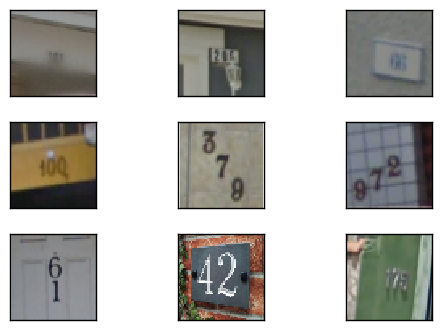

In [7]:
# Get the first images from the test-set.
images = images_resized[0:min(9,len(images_resized))]

# Plot the images and labels using our helper-function above.
plot_images(images=images, smooth=False)

<function matplotlib.pyplot.show>

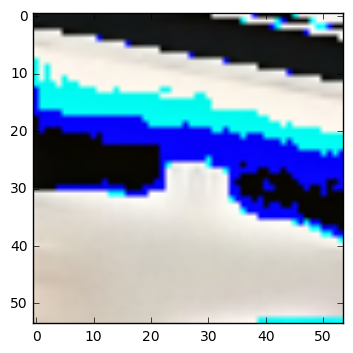

In [8]:
%matplotlib inline
plt.figure()
plt.imshow(images_normalised[0]); #images_resized
plt.show

In [9]:
def ohe_to_housenumbers(ohe_labels):
    lengths = ohe_labels[:,0,:]
    digits1 = ohe_labels[:,1,:]
    digits2 = ohe_labels[:,2,:]
    digits3 = ohe_labels[:,3,:]
    digits4 = ohe_labels[:,4,:]
    digits5 = ohe_labels[:,5,:]
    
    num_labels = len(ohe_labels)
    housenumbers = np.zeros(shape=num_labels, dtype=np.int)
    
    for i in range(num_labels):
        l = np.argmax(lengths[i])
        d1 = np.argmax(digits1[i])
        d2 = np.argmax(digits2[i])
        d3 = np.argmax(digits3[i])
        d4 = np.argmax(digits4[i])
        d5 = np.argmax(digits5[i])
        d = str(d1)+str(d2)+str(d3)+str(d4)+str(d5)
        housenumbers[i] = int(d[:min(l,5)])
        
    return housenumbers

In [10]:
num_labels = 11 # digits 0-9 and 10 for blank
num_logits = 6 # 5 digits plus number length
num_channels = 3 # RGB color image
image_size = 54

In [11]:
x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, num_channels], name='x')

y_true = tf.placeholder(tf.float32, shape=[None, num_logits,num_labels], name='y_true')

In [12]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        network_base = x_pretty.\
            apply(tf.image.rgb_to_grayscale).\
            conv2d(kernel=5, depth=48, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=128, name='layer_conv3', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=160, name='layer_conv4', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            dropout(0.95).\
            flatten().\
            fully_connected(size=2048, name='layer_fc1').\
            dropout(0.95).\
            fully_connected(size=1024, name='layer_fc2')
        y_pred1, loss1 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,0,:])
        y_pred2, loss2 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,1,:])
        y_pred3, loss3 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,2,:])
        y_pred4, loss4 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,3,:])
        y_pred5, loss5 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,4,:])
        y_pred6, loss6 = network_base.softmax_classifier(num_classes=num_labels, 
                                                         labels=y_true[:,5,:])
        loss = pt.create_composite_loss([loss1,loss2,loss3,loss4,loss5,loss6])
        y_pred = tf.pack([y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6],axis=1)
        
    return y_pred, loss

In [13]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [14]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [15]:
_, loss = create_network(training=True)

In [16]:
optimizer = tf.train.AdamOptimizer().minimize(loss,global_step=global_step)


In [17]:
y_pred, _ = create_network(training=False)

In [18]:
saver = tf.train.Saver()

In [ ]:
session = tf.Session()

In [23]:
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=model_folder)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.initialize_all_variables())

Trying to restore last checkpoint ...
Restored checkpoint from: ./logs/cnn-ver-3/model_cnn-ver-3-4800


In [24]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(images):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    labels = np.zeros(shape=(num_images, num_logits,num_labels), dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = ohe_to_housenumbers(session.run(y_pred, feed_dict=feed_dict))

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j


    return cls_pred

In [25]:
def print_predictions():   
    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    cls_pred = predict_cls(images_normalised)
    
    print(cls_pred)
    # Plot some examples of mis-classifications, if desired.
    print("Predictions:")
    plot_images(images=images,cls_pred=cls_pred, smooth=False)

[121]
Predictions:


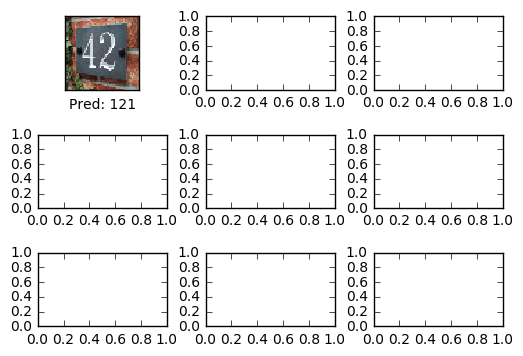

In [26]:
print_predictions()

In [27]:
session.close()